In [1]:
import h5py
import pandas as pd, numpy as np, matplotlib.pyplot as plt, gunzip
import seaborn as sns
import sys, os
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
import random
from scipy.stats import norm
from gtfparse import read_gtf
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import collections
import qnorm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score 
from collections import Counter
from scipy.spatial import distance
import torch
from torch import nn
import math
from sklearn.decomposition import PCA
torch.manual_seed(100)

### Helper function for gene length normalization

In [2]:
def gene_length_normalization(df_input,gene_len_info):
    gene_list = list(set(gencode.gene_name).intersection(set(df_input.index)))
    df_input = df_input.loc[gene_list,:]
    for gene in df_input.index:
        df_input.loc[gene,:] = df_input.loc[gene,:]/gene_len_info.length[np.where(gene_len_info.gene_name==gene)[0][0]]
    return df_input

### Read, clean, normalize and extract the rare biosample expression data

In [3]:
f = h5py.File('../data/archs4_gene_human_v2.1.h5','r')
x1 = f.get('data')
x2 = x1.get('expression')
exp_data = pd.DataFrame(data=x2)
y1 = f.get('meta')
y2 = y1.get('genes')
gene_sym = y2.get('gene_symbol')
gene_id = pd.DataFrame(data=gene_sym,columns=['gene_id'])
gene_id = gene_id.iloc[:,0].apply(lambda s: s.decode('utf-8'))
gene_id = pd.DataFrame(data=gene_id)
y1 = f.get('meta')
y3 = y1.get('samples')
geo_acc = y3.get('geo_accession')
samp_id = pd.DataFrame(data=geo_acc,columns=['geo_acc'])
samp_id = samp_id.iloc[:,0].apply(lambda s: s.decode('utf-8'))
samp_id = pd.DataFrame(data=samp_id)
exp_data.columns = list(samp_id.iloc[:,0])
exp_data.index = list(gene_id.iloc[:,0])
sample_anno = pd.read_csv('../results/sample_annotations_multi_hot',sep='\t',index_col=0)
gencode = read_gtf("../../genome_25kb/data/gencode.v41.annotation.gtf")
gene_len_info = pd.read_csv('../results/gene_length_longest_transcript',sep='\t')

/home/ajoshi/.conda/envs/aj_env/lib/python3.8/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
/home/ajoshi/.conda/envs/aj_env/lib/python3.8/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'hgnc_id', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'ont', 'protein_id', 'ccdsid', 'artif_dupl']


### We select only the brain biosamples to normalize

In [4]:
train_exp_data = exp_data[sample_anno.index[np.where(sample_anno.brain==1)[0]]]
train_exp_data = qnorm.quantile_normalize(np.log2(1+train_exp_data),axis=1)
train_exp_data = gene_length_normalization(train_exp_data,gene_len_info)
train_exp_data = np.transpose(train_exp_data)

### Prepare the data for GAN architecture

In [5]:
train_labels = torch.zeros(len(train_exp_data))
train_data = torch.tensor(train_exp_data.to_numpy())
train_set = [
    (train_data[i], train_labels[i]) for i in range(len(train_exp_data))
]

### Create a data loader for Pytorch, with train labels for the specific implementation, even though the purpose is unsupervised

In [6]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

### The Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(59425, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output
    
discriminator = Discriminator()

### The Generator

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(59425, 32768),
            nn.ReLU(),
            nn.Linear(32768, 2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Linear(2048, 16384),
            nn.ReLU(),
            nn.Linear(16384, 32768),
            nn.ReLU(),
            nn.Linear(32768, 59425),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

### Set the hyper-parameters

In [9]:
learning_rate = 0.0001
momentum = 0.2 #If using SGD with momentum as optimization
alpha = 0.2 #Learning rate decay, if using Adaptive gradient
num_epochs = 100
betas = (0.5,0.7) #If using Adam optimizer
loss_function = nn.BCELoss() # Binary Cross-entropy as an objective function

### Set the optimization techniques

In [10]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=learning_rate)

### Train the model

In [12]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 59425))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples.type(torch.float32))
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 59425))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == len(train_loader)-1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator} Loss G.: {loss_generator}")


Epoch: 1 Loss D.: 0.6933845281600952 Loss G.: 0.7017270922660828
Epoch: 10 Loss D.: 0.6914956569671631 Loss G.: 0.6982784867286682
Epoch: 20 Loss D.: 0.6935787200927734 Loss G.: 0.6971633434295654
Epoch: 30 Loss D.: 0.6919667720794678 Loss G.: 0.6942392587661743
Epoch: 40 Loss D.: 0.7045297461067857 Loss G.: 0.6873991243294588
Epoch: 50 Loss D.: 0.6113246239748767 Loss G.: 0.6982784867286682
Epoch: 60 Loss D.: 0.5230754700153684 Loss G.: 0.6184592503772886
Epoch: 70 Loss D.: 0.6735289040655383 Loss G.: 0.6129847763389083
Epoch: 80 Loss D.: 0.7236504194890478 Loss G.: 0.5817390257843197
Epoch: 90 Loss D.: 0.7973559903555498 Loss G.: 0.5239993452084663
Epoch: 100 Loss D.: 0.7997487666305298 Loss G.: 0.5245890019488459


### Generate the synthetic 'brain' samples

In [13]:
latent_space_samples = torch.randn(100, 59425)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()
generated_samples_frame = pd.DataFrame(data=generated_samples)

#### We choose a representative data example by finding the centroid of the brain samples in 59425 dimensions and then selecting the biosample closest to it. We compare all the generated biosamples with this representative biosample by computing the euclidean distance of all the generated biosamples from it, and viewing the histogram of these distances. The lower the scale of histogram and if most biosamples are towards teh lower end, the better the quality of the generated synthetic brain biosamples.

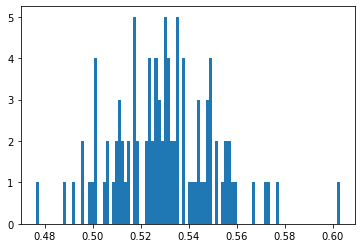

In [14]:
centroid = np.mean(train_exp_data,axis=0)
dists_from_centroid = [math.dist(centroid,train_exp_data.loc[sample,:]) for sample in train_exp_data.index]
ind_of_min_dist = dists_from_centroid.index(min(dists_from_centroid))
gen_biosamples_distances=[math.dist(train_exp_data.iloc[ind_of_min_dist,:],
                                    generated_samples_frame.iloc[j,0:]) for j in range(len(generated_samples_frame))]
hist = plt.hist(gen_biosamples_distances,bins=100)